In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving utils.py to utils.py
Saving model_base.py to model_base.py
Saving logger.py to logger.py
Saving hyperparameters.json to hyperparameters.json


In [3]:
!pip3 install imutils

  Running setup.py bdist_wheel for imutils ... - \ done
  Stored in directory: /root/.cache/pip/wheels/4c/ff/aa/824fb9efc5b8c740d54cd8bc19c7e85fbb8d115c77e56812c7
Successfully built imutils


In [4]:
import cv2
from PIL import Image
import numpy as np
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import argparse
import random
import pickle
import os

tf.reset_default_graph()

np.random.seed(42)
tf.set_random_seed(42)

Using TensorFlow backend.


In [5]:
imagePaths_1 = sorted(list(paths.list_images("drive/My Drive/Dataset/dataset1/real")))
random.shuffle(imagePaths_1)

print(len(imagePaths_1))

120


In [0]:
data = []
labels = []

In [0]:
#set image dimensions
IMAGE_DIMS = (80, 80, 3)

In [0]:
#load the data into data and list
for imagePath in imagePaths_1:
  image = cv2.imread(imagePath.replace("\\", ""))
  image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
  image = img_to_array(image)
  data.append(image)
    
  l = imagePath[-7:-4]
  labels.append(l)

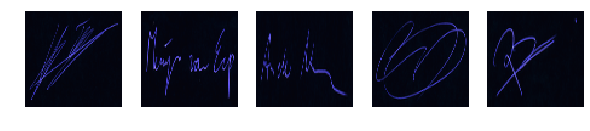

In [9]:
#see the 1st 5 examples
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = data[index].reshape(IMAGE_DIMS[1], IMAGE_DIMS[0],3)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [10]:
#preprocess the labels
labels = np.asarray(labels)
labels = labels.flatten()
labels = labels.tolist()
labels = [str(r) for r in labels]
labels = [int(r) for r in labels]
labels[:] = [x-1 for x in labels]
print(len(set(labels))) #number of distinct labels i.e. users
print(len(labels))#number of labels

12
120


In [11]:
#labels of the 1st 5 images
print(labels[:n_samples])

[2, 0, 6, 9, 4]


In [0]:
#split the data for training, validation and testing
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

val_data = np.array(val_data)
val_labels = np.array(val_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [0]:
#number of training and validation examples
train_num_examples = len(train_data)
val_num_examples = len(val_data)

In [14]:
X_train = train_data
X_valid = val_data

y_train = train_labels
y_valid = val_labels

X_test = test_data
y_test = test_labels

print(len(X_train),len(X_valid),len(X_test))

print(len(y_train),len(y_valid),len(y_test))

76 24 20
76 24 20


In [0]:
#preprocess the images
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

from PIL import ImageEnhance
def preprocessing_function(img):
  
    img = img * 255
    img = Image.fromarray(img.astype('uint8'), 'RGB')

    return np.array(img) / 255

train_datagen = ImageDataGenerator()
train_datagen_augmented = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocessing_function)
inference_datagen = ImageDataGenerator()
train_datagen.fit(X_train)
train_datagen_augmented.fit(X_train)
inference_datagen.fit(X_valid)
inference_datagen.fit(X_test)

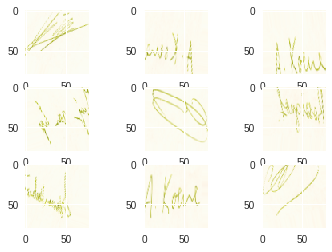

In [16]:
#augment the training images
fig = plt.figure()

n = 0

graph_size = 3

for x_batch, y_batch in train_datagen_augmented.flow(X_train, y_train, batch_size=1):
    a=fig.add_subplot(graph_size, graph_size, n+1)
    imgplot = plt.imshow(x_batch[0])
    n = n + 1
    if n > 8:
        break

    
plt.show()

In [0]:
#important functions for implementing the algorithm
def conv_caps_layer(input_layer, capsules_size, nb_filters, kernel, stride=2):
    
    capsules = tf.contrib.layers.conv2d(
        input_layer, nb_filters * capsules_size, kernel, stride, padding="VALID")
    shape = capsules.get_shape().as_list()
    capsules = tf.reshape(capsules, shape=(-1, np.prod(shape[1:3]) * nb_filters, capsules_size, 1))
    return squash(capsules)

def routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=4):
   
    # Start the routing algorithm
    for it in range(iterations):
        with tf.variable_scope('routing_' + str(it)):
            c_ij = tf.nn.softmax(b_ij, axis=2)

            s_j = tf.multiply(c_ij, u_hat)
            s_j = tf.reduce_sum(s_j, axis=1, keepdims=True)
            
            v_j = squash(s_j)
            v_j_tiled = tf.tile(v_j, [1, nb_capsules_p, 1, 1, 1])
            u_dot_v = tf.matmul(u_hat, v_j_tiled, transpose_a=True)
            b_ij += tf.reduce_sum(u_dot_v, axis=0, keepdims=True)
            
    return tf.squeeze(v_j, axis=1)

def fully_connected_caps_layer(input_layer, capsules_size, nb_capsules, iterations=4):
   
    shape = input_layer.get_shape().as_list()
    # Get the size of each capsule in the previous layer and the current layer.
    len_u_i = np.prod(shape[2])
    len_v_j = capsules_size
    # Get the number of capsule in the layer bellow.
    nb_capsules_p = np.prod(shape[1])

    # w_ij: Used to compute u_hat by multiplying the output ui of a capsule in the layer below
    # with this matrix
    # [nb_capsules_p, nb_capsules, len_v_j, len_u_i]
    _init = tf.random_normal_initializer(stddev=0.01, seed=0)
    _shape = (nb_capsules_p, nb_capsules, len_v_j, len_u_i)
    w_ij = tf.get_variable('weight', shape=_shape, dtype=tf.float32, initializer=_init)

    # Adding one dimension to the input [batch_size, nb_capsules_p,    length(u_i), 1] ->
    #                                   [batch_size, nb_capsules_p, 1, length(u_i), 1]
    # To allow the next dot product
    input_layer = tf.reshape(input_layer, shape=(-1, nb_capsules_p, 1, len_u_i, 1))
    input_layer = tf.tile(input_layer, [1, 1, nb_capsules, 1, 1])

    # Eq.2, calc u_hat
    # Prediction uj|i made by capsule i
    # w_ij:  [              nb_capsules_p, nb_capsules, len_v_j,  len_u_i, ]
    # input: [batch_size,   nb_capsules_p, nb_capsules, len_ui,   1]
    # u_hat: [batch_size,   nb_capsules_p, nb_capsules, len_v_j, 1]
    # Each capsule of the previous layer capsule layer is associated to a capsule of this layer
    u_hat = tf.einsum('abdc,iabcf->iabdf', w_ij, input_layer)

    # bij are the log prior probabilities that capsule i should be coupled to capsule j
    # [nb_capsules_p, nb_capsules, 1, 1]
    b_ij = tf.zeros(shape=[nb_capsules_p, nb_capsules, 1, 1], dtype=np.float32)

    return routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=iterations)

def squash(vector):
    
    vector += 0.00001     
    vec_squared_norm = tf.reduce_sum(tf.square(vector), -2, keepdims=True)
    scalar_factor = vec_squared_norm / (1 + vec_squared_norm) / tf.sqrt(vec_squared_norm)
    vec_squashed = scalar_factor * vector  # element-wise
    return(vec_squashed)

In [0]:
#defining the class for model
from model_base import ModelBase


class ModelSignature(ModelBase):
    """
        ModelSignature.
        This class is used to create the conv graph using:
            Dynamic Routing Between Capsules
    """

    # Numbers of label to predict
    NB_LABELS = 12

    def __init__(self, model_name, output_folder):
        ModelBase.__init__(self, model_name, output_folder=output_folder)

    def _build_inputs(self):
        """
            Build tensorflow inputs
            (Placeholder)
            **return: **
                *tf_images: Images Placeholder
                *tf_labels: Labels Placeholder
        """
        tf_images = tf.placeholder(tf.float32, [None, 80, 80, 3], name='images')
        tf_labels = tf.placeholder(tf.int64, [None], name='labels')
        return tf_images, tf_labels

    def _build_main_network(self, images, conv_2_dropout):
       
        # First BLock:
        # Layer 1: Convolution.
        shape = (self.h.conv_1_size, self.h.conv_1_size, 3, self.h.conv_1_nb)
        conv1 = self._create_conv(self.tf_images, shape, relu=True, max_pooling=False, padding='VALID')
        # Layer 2: Convolution.
        conv1 = tf.nn.dropout(conv1, keep_prob=conv_2_dropout)

        # Create the first capsules layer
        caps1 = conv_caps_layer(
            input_layer=conv1,
            capsules_size=self.h.caps_1_vec_len,
            nb_filters=self.h.caps_1_nb_filter,
            kernel=self.h.caps_1_size)
        # Create the second capsules layer used to predict the output
        caps2 = fully_connected_caps_layer(
            input_layer=caps1,
            capsules_size=self.h.caps_2_vec_len,
            nb_capsules=self.NB_LABELS,
            iterations=self.h.routing_steps)

        return caps1, caps2

    def _build_decoder(self, caps2, one_hot_labels, batch_size):
       
        labels = tf.reshape(one_hot_labels, (-1, self.NB_LABELS, 1))
        mask = tf.matmul(tf.squeeze(caps2), labels, transpose_a=True)
        # Select the good capsule vector
        capsule_vector = tf.reshape(mask, shape=(batch_size, self.h.caps_2_vec_len))
        # Reconstruct image
        fc1 = tf.contrib.layers.fully_connected(capsule_vector, num_outputs=400)
        fc1 = tf.reshape(fc1, shape=(batch_size, 5, 5, 16))
        upsample1 = tf.image.resize_nearest_neighbor(fc1, (8, 8))
        conv1 = tf.layers.conv2d(upsample1, 4, (3,3), padding='same', activation=tf.nn.relu)

        upsample2 = tf.image.resize_nearest_neighbor(conv1, (16, 16))
        conv2 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)

        upsample3 = tf.image.resize_nearest_neighbor(conv2, (32, 32))
        conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
        
        upsample4 = tf.image.resize_nearest_neighbor(conv2, (80, 80))
        conv7 = tf.layers.conv2d(upsample4, 32, (3,3), padding='same', activation=tf.nn.relu)

        # 3 channel for RBG
        logits = tf.layers.conv2d(conv7, 3, (3,3), padding='same', activation=None)
        decoded = tf.nn.sigmoid(logits, name='decoded')
        tf.summary.image('reconstruction_img', decoded)

        return decoded

    def init(self):
        """
            Init the graph
        """
        # Get graph inputs
        self.tf_images, self.tf_labels = self._build_inputs()
        # Dropout inputs
        self.tf_conv_2_dropout = tf.placeholder(tf.float32, shape=(), name='conv_2_dropout')
        # Dynamic batch size
        batch_size = tf.shape(self.tf_images)[0]
        # Translate labels to one hot array
        one_hot_labels = tf.one_hot(self.tf_labels, depth=self.NB_LABELS)
        # Create the first convolution and the CapsNet
        self.tf_caps1, self.tf_caps2 = self._build_main_network(self.tf_images, self.tf_conv_2_dropout)

        # Build the images reconstruction
        self.tf_decoded = self._build_decoder(self.tf_caps2, one_hot_labels, batch_size)

        # Build the loss
        _loss = self._build_loss(
            self.tf_caps2, one_hot_labels, self.tf_labels, self.tf_decoded, self.tf_images)
        (self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_predicted_class,
         self.tf_correct_prediction, self.tf_accuracy, self.tf_loss, self.tf_margin_loss,
         self.tf_reconstruction_loss) = _loss

        # Build optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.h.learning_rate)
        self.tf_optimizer = optimizer.minimize(self.tf_loss, global_step=tf.Variable(0, trainable=False))

        # Log value into tensorboard
        tf.summary.scalar('margin_loss', self.tf_margin_loss)
        tf.summary.scalar('accuracy', self.tf_accuracy)
        tf.summary.scalar('total_loss', self.tf_loss)
        tf.summary.scalar('reconstruction_loss', self.tf_reconstruction_loss)

        self.tf_test = tf.random_uniform([2], minval=0, maxval=None, dtype=tf.float32, seed=None, name="tf_test")

        self.init_session()


    def _build_loss(self, caps2, one_hot_labels, labels, decoded, images):
        """
            Build the loss of the graph
        """
        # Get the length of each capsule
        capsules_length = tf.sqrt(tf.reduce_sum(tf.square(caps2), axis=2, keepdims=True))

        max_l = tf.square(tf.maximum(0., 0.9 - capsules_length))
        max_l = tf.reshape(max_l, shape=(-1, self.NB_LABELS))
        max_r = tf.square(tf.maximum(0., capsules_length - 0.1))
        max_r = tf.reshape(max_r, shape=(-1, self.NB_LABELS))
        t_c = one_hot_labels
        m_loss = t_c * max_l + 0.5 * (1 - t_c) * max_r
        margin_loss_sum = tf.reduce_sum(m_loss, axis=1)
        margin_loss = tf.reduce_mean(margin_loss_sum)

        # Reconstruction loss
        loss_squared_rec = tf.square(decoded - images)
        reconstruction_loss = tf.reduce_mean(loss_squared_rec)

        # 3. Total loss
        loss = margin_loss + (0.0005 * reconstruction_loss)

        # Accuracy
        predicted_class = tf.argmax(capsules_length, axis=1)
        predicted_class = tf.reshape(predicted_class, [tf.shape(capsules_length)[0]])
        correct_prediction = tf.equal(predicted_class, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        return (loss_squared_rec, margin_loss_sum, predicted_class, correct_prediction, accuracy,
                loss, margin_loss, reconstruction_loss)

    def optimize(self, images, labels, tb_save=True):
       
        tensors = [self.tf_optimizer, self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        _, loss, acc, summary = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: self.h.conv_2_dropout
        })

        if tb_save:
            # Write data to tensorboard
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    def evaluate(self, images, labels, tb_train_save=False, tb_test_save=False):
       
        tensors = [self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        loss, acc, summary = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images,
                self.tf_labels: labels,
                self.tf_conv_2_dropout: 1.
            })

        if tb_test_save:
            # Write data to tensorboard
            self.test_writer.add_summary(summary, self.test_writer_it)
            self.test_writer_it += 1

        if tb_train_save:
            # Write data to tensorboard
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    def predict(self, images):
       
        tensors = [self.tf_caps2]

        caps2 = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_conv_2_dropout: 1.
        })[0]

        caps2 = np.sqrt(np.sum(np.square(caps2), axis=2, keepdims=True))
        caps2 = np.reshape(caps2, (len(images), self.NB_LABELS))
        
        softmax = np.exp(caps2) / np.sum(np.exp(caps2), axis=1, keepdims=True)

        return softmax

    def reconstruction(self, images, labels):
       
        tensors = [self.tf_decoded]

        decoded = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: 1.
        })[0]

        return decoded

    def evaluate_dataset(self, images, labels, batch_size=10):
       
        tensors = [self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_correct_prediction,
                   self.tf_predicted_class]

        loss_squared_rec_list = None
        margin_loss_sum_list = None
        correct_prediction_list = None
        predicted_class = None

        b = 0
        for batch in self.get_batches([images, labels], batch_size, shuffle=False):
            images_batch, labels_batch = batch
            loss_squared_rec, margin_loss_sum, correct_prediction, classes = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images_batch,
                self.tf_labels: labels_batch,
                self.tf_conv_2_dropout: 1.
            })
            if loss_squared_rec_list is not None:
                predicted_class = np.concatenate((predicted_class, classes))
                loss_squared_rec_list = np.concatenate((loss_squared_rec_list, loss_squared_rec))
                margin_loss_sum_list = np.concatenate((margin_loss_sum_list, margin_loss_sum))
                correct_prediction_list = np.concatenate((correct_prediction_list, correct_prediction))
            else:
                predicted_class = classes
                loss_squared_rec_list = loss_squared_rec
                margin_loss_sum_list = margin_loss_sum
                correct_prediction_list = correct_prediction
            b += batch_size

        margin_loss = np.mean(margin_loss_sum_list)
        reconstruction_loss = np.mean(loss_squared_rec_list)
        accuracy = np.mean(correct_prediction_list)

        loss = margin_loss

        return loss, accuracy, predicted_class

In [0]:
# Init model
model = ModelSignature("Signature", output_folder="drive/My Drive/outputs")
model.init()

In [20]:
### Train your model here.

BATCH_SIZE = 50

# Utils method to print the current progression
def plot_progression(b, cost, acc, label): print(
    "[%s] Batch ID = %s, loss = %s, acc = %s" % (label, b, cost, acc))

# Training pipeline
b = 0
valid_batch = inference_datagen.flow(X_valid, y_valid, batch_size=BATCH_SIZE)
best_validation_loss = None
augmented_factor = 0.99
decrease_factor = 0.90
train_batches = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
augmented_train_batches = train_datagen_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE)

while True:
    next_batch = next(
        augmented_train_batches if random.uniform(0, 1) < augmented_factor else train_batches)
    x_batch, y_batch = next_batch

    ### Training
    cost, acc = model.optimize(x_batch, y_batch)
    ### Validation
    x_batch, y_batch = next(valid_batch, None)
    # Retrieve the cost and acc on this validation batch and save it in tensorboard
    cost_val, acc_val = model.evaluate(x_batch, y_batch, tb_test_save=True)

    if b % 10 == 0: # Plot the last results
        plot_progression(b, cost, acc, "Train")
        plot_progression(b, cost_val, acc_val, "Validation")
    if b % 1000 == 0: # Test the model on all the validation
        print("Evaluate full validation dataset ...")
        loss, acc, _ = model.evaluate_dataset(X_valid, y_valid)
        print("Current loss: %s Best loss: %s" % (loss, best_validation_loss))
        plot_progression(b, loss, acc, "TOTAL Validation")
        if best_validation_loss is None or loss < best_validation_loss:
            best_validation_loss = loss
            model.save()
        augmented_factor = augmented_factor * decrease_factor
        print("Augmented Factor = %s" % augmented_factor)
    if b==2700:
      model.save()
      break
    b += 1

[Train] Batch ID = 0, loss = 4.2165318, acc = 0.06
[Validation] Batch ID = 0, loss = 4.414993, acc = 0.125
Evaluate full validation dataset ...


ModelBase::Saving model ...


Current loss: 4.4150705 Best loss: None
[TOTAL Validation] Batch ID = 0, loss = 4.4150705, acc = 0.1


ModelBase::Model successfully saved here: drive/My Drive/outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--Signature--1543758034.3346882


Augmented Factor = 0.891
[Train] Batch ID = 10, loss = 4.4453287, acc = 0.07692308
[Validation] Batch ID = 10, loss = 4.443924, acc = 0.125
[Train] Batch ID = 20, loss = 3.980426, acc = 0.06
[Validation] Batch ID = 20, loss = 3.6438935, acc = 0.125
[Train] Batch ID = 30, loss = 1.8637509, acc = 0.08
[Validation] Batch ID = 30, loss = 1.5023264, acc = 0.125
[Train] Batch ID = 40, loss = 0.92305267, acc = 0.18
[Validation] Batch ID = 40, loss = 0.88984245, acc = 0.125
[Train] Batch ID = 50, loss = 0.92625624, acc = 0.08
[Validation] Batch ID = 50, loss = 0.7219672, acc = 0.041666668
[Train] Batch ID = 60, loss = 0.6821485, acc = 0.115384616
[Validation] Batch ID = 60, loss = 1.0001861, acc = 0.041666668
[Train] Batch ID = 70, loss = 0.70383465, acc = 0.07692308
[Validation] Batch ID = 70, loss = 0.7436541, acc = 0.20833333
[Train] Batch ID = 80, loss = 0.84541214, acc = 0.07692308
[Validation] Batch ID = 80, loss = 0.8694584, acc = 0.041666668
[Train] Batch ID = 90, loss = 0.7929404, acc

ModelBase::Saving model ...


[Train] Batch ID = 1000, loss = 0.113487, acc = 0.96
[Validation] Batch ID = 1000, loss = 0.049318936, acc = 1.0
Evaluate full validation dataset ...
Current loss: 0.046880886 Best loss: 4.4150705
[TOTAL Validation] Batch ID = 1000, loss = 0.046880886, acc = 1.0


ModelBase::Model successfully saved here: drive/My Drive/outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--Signature--1543758034.3346882


Augmented Factor = 0.8019000000000001
[Train] Batch ID = 1010, loss = 0.13360982, acc = 1.0
[Validation] Batch ID = 1010, loss = 0.040999733, acc = 1.0
[Train] Batch ID = 1020, loss = 0.0047938824, acc = 1.0
[Validation] Batch ID = 1020, loss = 0.040821943, acc = 1.0
[Train] Batch ID = 1030, loss = 0.13749713, acc = 0.84615386
[Validation] Batch ID = 1030, loss = 0.031422358, acc = 1.0
[Train] Batch ID = 1040, loss = 0.0029311904, acc = 1.0
[Validation] Batch ID = 1040, loss = 0.033967245, acc = 1.0
[Train] Batch ID = 1050, loss = 0.08244606, acc = 1.0
[Validation] Batch ID = 1050, loss = 0.04816398, acc = 1.0
[Train] Batch ID = 1060, loss = 0.09325196, acc = 1.0
[Validation] Batch ID = 1060, loss = 0.038518928, acc = 1.0
[Train] Batch ID = 1070, loss = 0.09995513, acc = 1.0
[Validation] Batch ID = 1070, loss = 0.04286686, acc = 1.0
[Train] Batch ID = 1080, loss = 0.0052576233, acc = 1.0
[Validation] Batch ID = 1080, loss = 0.038128156, acc = 1.0
[Train] Batch ID = 1090, loss = 0.00375

ModelBase::Saving model ...


[Train] Batch ID = 2000, loss = 0.041967787, acc = 1.0
[Validation] Batch ID = 2000, loss = 0.03978822, acc = 1.0
Evaluate full validation dataset ...
Current loss: 0.037299894 Best loss: 0.046880886
[TOTAL Validation] Batch ID = 2000, loss = 0.037299894, acc = 1.0


ModelBase::Model successfully saved here: drive/My Drive/outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--Signature--1543758034.3346882


Augmented Factor = 0.7217100000000001
[Train] Batch ID = 2010, loss = 0.03959026, acc = 1.0
[Validation] Batch ID = 2010, loss = 0.037695225, acc = 1.0
[Train] Batch ID = 2020, loss = 0.042616602, acc = 1.0
[Validation] Batch ID = 2020, loss = 0.03056243, acc = 1.0
[Train] Batch ID = 2030, loss = 0.04645215, acc = 1.0
[Validation] Batch ID = 2030, loss = 0.030947024, acc = 1.0
[Train] Batch ID = 2040, loss = 0.04170074, acc = 1.0
[Validation] Batch ID = 2040, loss = 0.03238252, acc = 1.0
[Train] Batch ID = 2050, loss = 0.000692644, acc = 1.0
[Validation] Batch ID = 2050, loss = 0.05744784, acc = 1.0
[Train] Batch ID = 2060, loss = 0.040112954, acc = 1.0
[Validation] Batch ID = 2060, loss = 0.031129092, acc = 1.0
[Train] Batch ID = 2070, loss = 0.00013679646, acc = 1.0
[Validation] Batch ID = 2070, loss = 0.020534081, acc = 1.0
[Train] Batch ID = 2080, loss = 0.002065846, acc = 1.0
[Validation] Batch ID = 2080, loss = 0.04264216, acc = 1.0
[Train] Batch ID = 2090, loss = 0.0004650058, a

ModelBase::Saving model ...


[Train] Batch ID = 2700, loss = 0.022322468, acc = 1.0
[Validation] Batch ID = 2700, loss = 0.03537451, acc = 1.0


ModelBase::Model successfully saved here: drive/My Drive/outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--Signature--1543758034.3346882


In [21]:
# Test the model on the test set

loss, acc, predicted_class = model.evaluate_dataset(X_test, y_test)

print("Test Accuracy = ", acc)
print("Test Loss = ", loss)
print(predicted_class)
print(len(predicted_class))

Test Accuracy =  1.0
Test Loss =  0.024634711
[ 0  5  8  6  6  0  5  2  6  7  4  2  0 11  2  1  4  3  1  9]
20


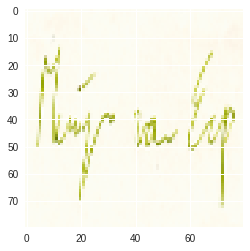

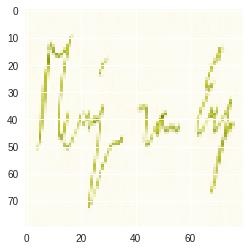

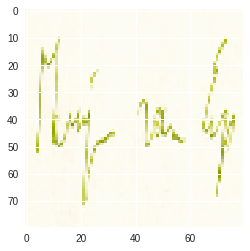

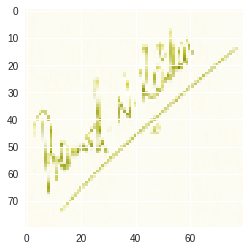

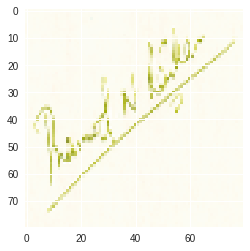

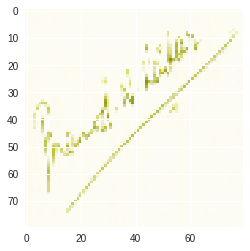

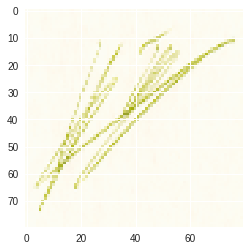

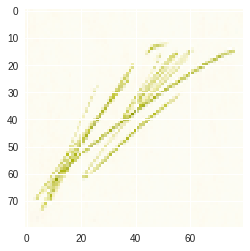

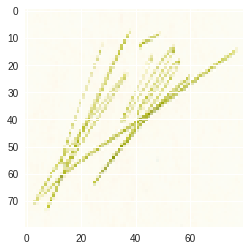

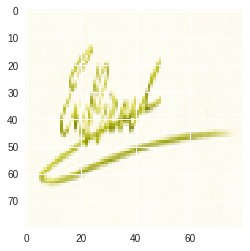

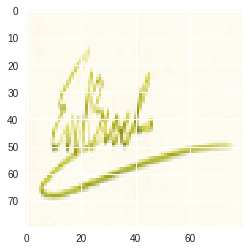

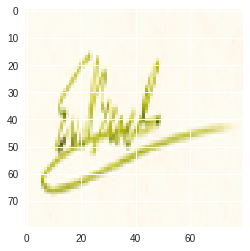

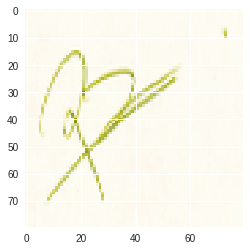

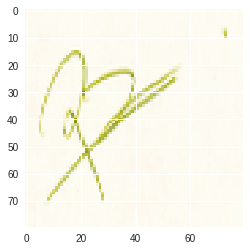

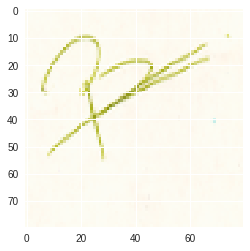

In [22]:
#run the next 3 blocks for predictions
import array as arr
a = arr.array('i',[1,2,3,4,5,6,7,8,9,10,11,12])
predicted_id_to_user = ["001","002","003","004","005","006","007","008","009","010","011","012"]

images1 = []
path = sorted(list(paths.list_images("drive/My Drive/TestDriveData1")))
# Read all image from the folder
for imagePath in path:
  image = cv2.imread(imagePath.replace("\\",""))
  image = cv2.resize(image,(80, 80),3)
  plt.imshow(image)
  plt.show()
  image = np.array(image) / 255
  images1.append(image)

In [0]:
# Get the prediction
predictions_for_real = model.predict(images1)

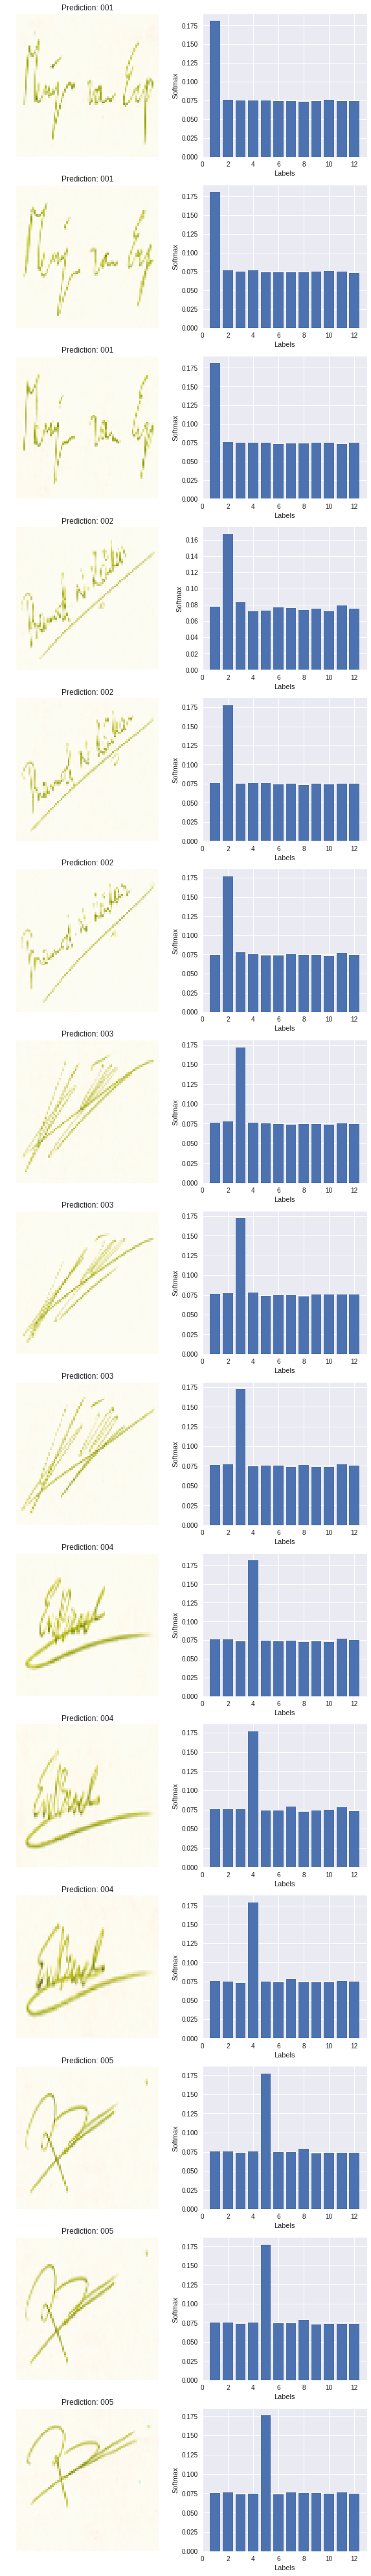

In [24]:
# Plot the result
fig, axs = plt.subplots(15, 2, figsize=(10, 72))
axs = axs.ravel()
for i in range(30):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(images1[i // 2])
        axs[i].set_title("Prediction: %s" % predicted_id_to_user[np.argmax(predictions_for_real[i//2])])
    else:
        axs[i].bar(a, predictions_for_real[i // 2])
        axs[i].set_ylabel("Softmax")
        axs[i].set_xlabel("Labels")

plt.show()

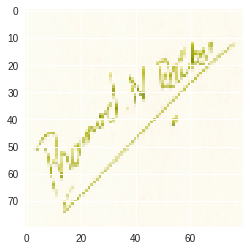

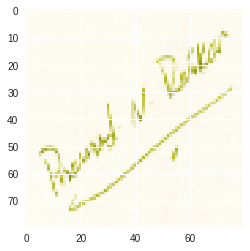

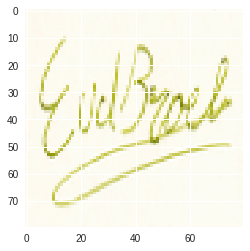

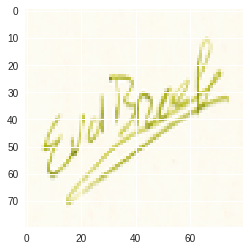

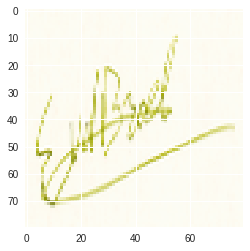

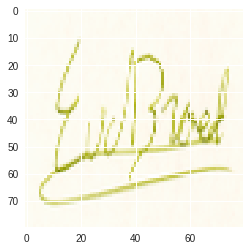

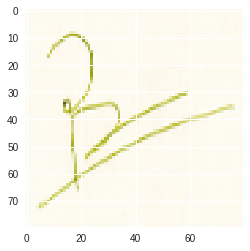

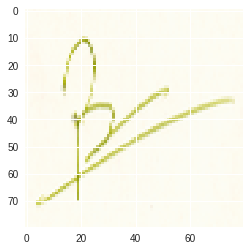

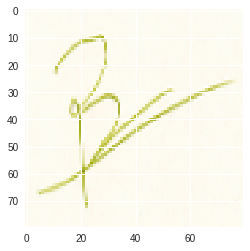

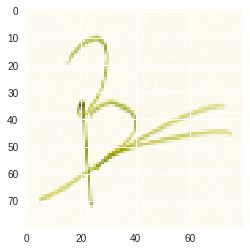

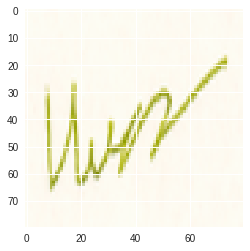

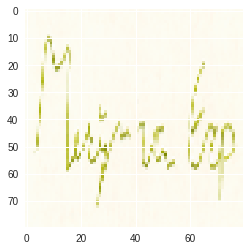

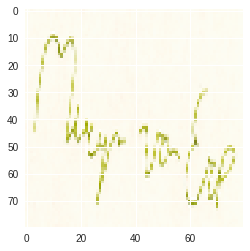

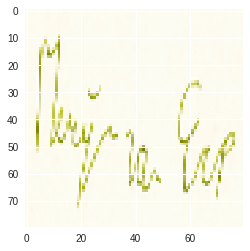

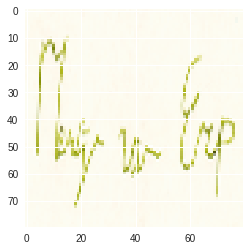

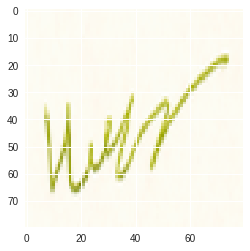

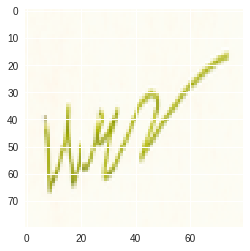

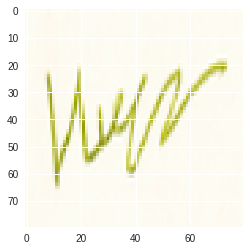

In [25]:
### Load the images and plot them here.
images3 = []
path = sorted(list(paths.list_images("drive/My Drive/TestDriveData2")))
# Read all image into the folder
for imagePath in path:
  image = cv2.imread(imagePath.replace("\\",""))
  image = cv2.resize(image,(80, 80),3)
  plt.imshow(image)
  plt.show()
  image = np.array(image) / 255
  images3.append(image)

In [0]:
# Get the prediction
predictions_for_forge = model.predict(images3)

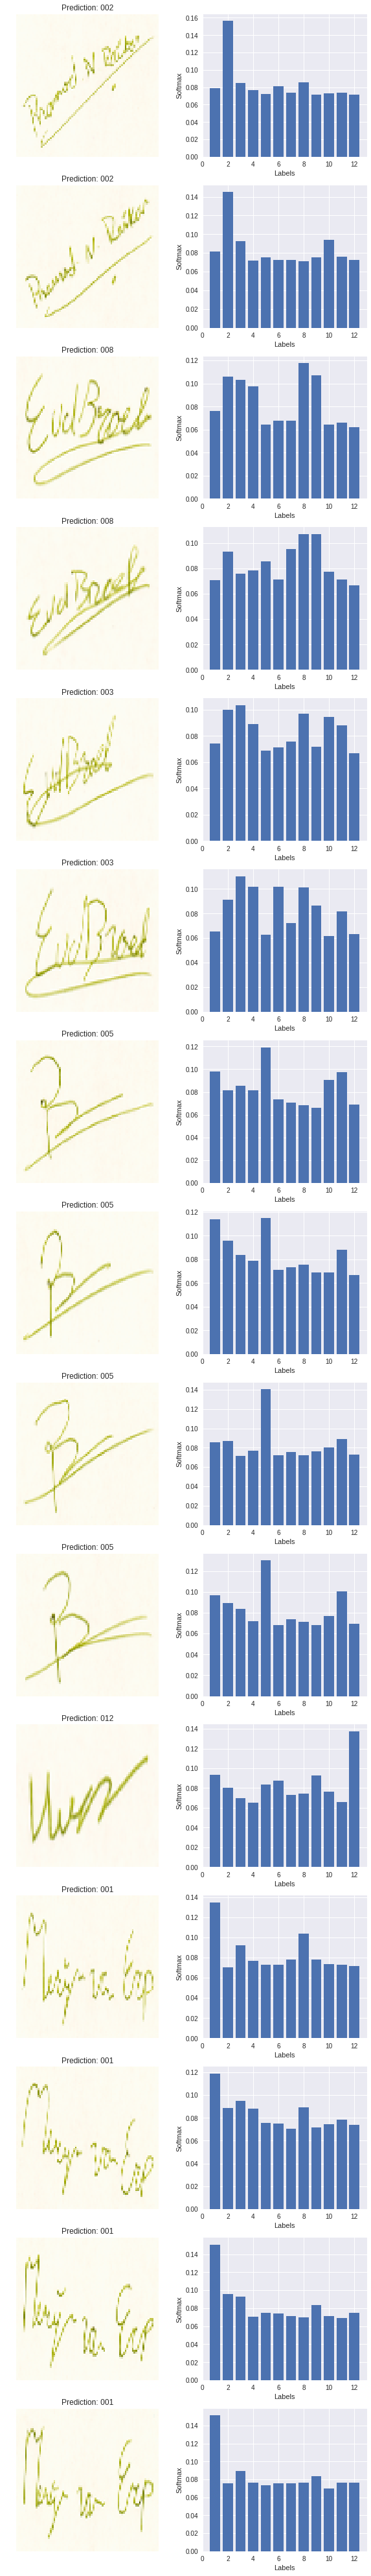

In [27]:
# Plot the result
fig, axs = plt.subplots(15, 2, figsize=(10, 72))
axs = axs.ravel()
for i in range(30):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(images3[i // 2])
        axs[i].set_title("Prediction: %s" % predicted_id_to_user[np.argmax(predictions_for_forge[i // 2])])
    else:
        axs[i].bar(a, predictions_for_forge[i // 2])
        axs[i].set_ylabel("Softmax")
        axs[i].set_xlabel("Labels")

plt.show()